# Framework which calculates result of algorithm and plots it

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from time import localtime, strftime

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 7)

In [28]:
# Number of samples in each class

TEST_SAMPLE_NUMBER = 57092
TRAIN_SAMPLE_NUMBER = 285998

# array1: [sX1; sY1; sX2; sY2; ...]
# array2: [eX1; eY1; eX2; eY2; ...]
# output: [dist((sX1, sY1), (eX1, eY1)), dist((sX1, sY1), (eX1, eY1)),
#          dist((sX2, sY2), (eX2, eY2)), dist((sX2, sY2), (eX2, eY2)), ...]

def distance_for_each_point(array1, array2):
    error_template = "Array lengths should be equal. len(array1): {len1}, len(array2): {len2}"
    assert (len(array1) == len(array2)), error_template.format(len1=len(array1), len2=len(array2))
    
    # for one-dimension arrays np.linalg.norm works in one way and for two-dimension in other
    if array1.ndim == 1:
        length = len(array1)
        # array1[i:i+2] -- point i from first array
        # np.linalg.norm -- calculate distance between points
        distance = np.array([np.linalg.norm(array1[i:i+2] - array2[i:i+2]) for i in range(0,length,2)])
        result = np.array([[d, d] for d in distance]).flatten()
    else:
        result = np.array([distance_for_each_point(array1[i], array2[i]) for i in range(len(array1))])
    
    return result

# data may be present as [n_features * n_samples] or [n_samples * n_features] 
def to_model(df):
    return np.array(df).T

def distance(test_results, predicted_results):
    return distance_for_each_point(np.array(test_results), predicted_results).sum() / TEST_SAMPLE_NUMBER / 2

def framework(function, test_results, parameter_name, list_of_values, **other_parameters):
    log_file_name = "src/Logs/{date}_predicted_coordinates_{function_name}_{parameter_name}_".format(
        date=strftime("%Y%m%d", localtime()), function_name=function.__name__, parameter_name=parameter_name)
    plot_file_name = "src/Plots/{date}_{function_name}_difference_by_{parameter_name}.png".format(
        date=strftime("%Y%m%d", localtime()), function_name=function.__name__, parameter_name=parameter_name)
    
    # we will keep results for each configuration here
    result = []

    for i, value in enumerate(list_of_values):
        print("{cur}/{num}: {time}".format(cur=i+1, num=len(list_of_values), time=strftime("%Y-%m-%d %H:%M:%S", localtime())))
        other_parameters[parameter_name] = value        
        predicted_results = function(**other_parameters)
        np.save(log_file_name + str(value), predicted_results)
        result.append(distance(test_results, predicted_results))
        
    print("done! {time}".format(time=strftime("%Y-%m-%d %H:%M:%S", localtime())))
        
    ind = list_of_values
    number = len(ind)
    width = 2 / number
    result_bar = plt.bar(range(number), result, width, color='g')

    plt.ylabel('Average difference')
    plt.xlabel(parameter_name)
    plt.title("Difference between real points and predicted by {parameter_name} in {function_name}".format(
        function_name=function.__name__, parameter_name=parameter_name))
    plt.xticks(np.array(range(number)) + width/2, ind)
    plt.savefig(plot_file_name)    

In [5]:
# reading data from .csv files

test_data = pd.read_csv('src/test_data_points.csv', index_col=0)
train_data = pd.read_csv('src/train_data_points.csv', index_col=0)

# split ten frames in input and output data (we want to predict output by input)
test_results = test_data[5:10]
test_data = test_data[:5]

train_results = train_data[5:10]
train_data = train_data[:5]

In [11]:
def baseline(dataframe, start_point_index=0, number_of_points_to_return=5):
    error_template = "Start point index should be less than last point. Start point index: {st}, last point index: {end}"
    assert (start_point_index < len(dataframe) - 1), error_template.format(st=start_point_index, end=len(dataframe) - 1)
    
    start_point = np.array(dataframe)[start_point_index]
    last_but_one_point = np.array(dataframe)[-2]
    end_point = np.array(dataframe)[-1]
    
    distance = distance_for_each_point(end_point, start_point)
    normalized_motion_vector = (end_point - start_point) / distance
    normalized_motion_vector[np.where(distance == 0)] = 0
    last_vector_length = distance_for_each_point(end_point, last_but_one_point)
    
    motion_vector = normalized_motion_vector * last_vector_length
    result = []
    for i in range(number_of_points_to_return):
        result.append(end_point + (i + 1) * motion_vector)
        
    return np.array(result)

1/4: 2016-10-10 15:30:51
2/4: 2016-10-10 15:31:11
3/4: 2016-10-10 15:31:31
4/4: 2016-10-10 15:31:50


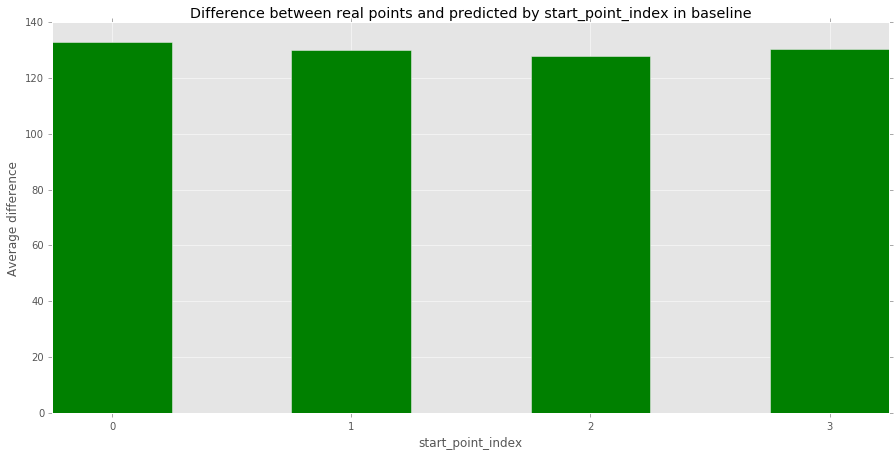

In [24]:
framework(function=baseline, test_results=test_results, parameter_name="start_point_index", list_of_values=range(4),
          dataframe=test_data)

In [20]:
from sklearn.ensemble import RandomForestRegressor

def random_forest_regressor(n_estimators, train_data, train_results, test_data):
    est = RandomForestRegressor(n_estimators=n_estimators)
    est.fit(to_model(train_data), to_model(train_results))
    return (est.predict(to_model(test_data))).T

1/4: 2016-10-10 15:32:10
2/4: 2016-10-10 15:34:21
3/4: 2016-10-10 15:38:27
4/4: 2016-10-10 15:44:22


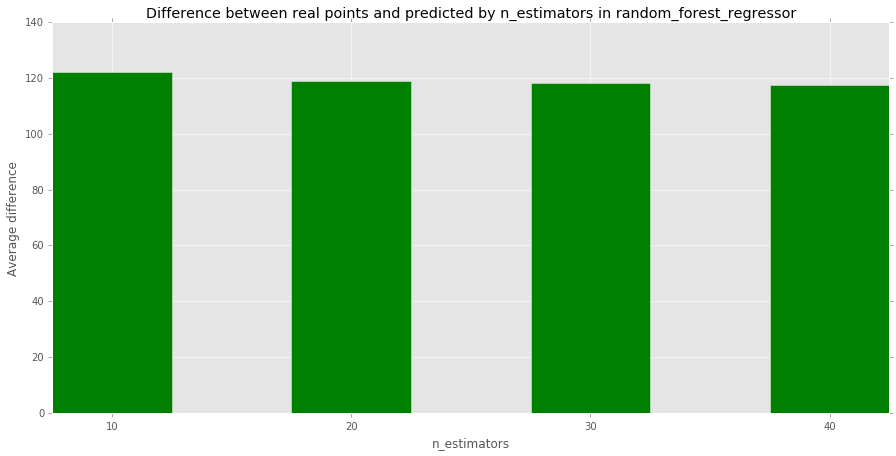

In [25]:
framework(function=random_forest_regressor, test_results=test_results, parameter_name="n_estimators",
          list_of_values=range(10, 50, 10), train_data=train_data, train_results=train_results, test_data=test_data)

In [27]:
from sklearn.neighbors import KNeighborsRegressor

# n_neighbors by defalt is 5;         to compare: range(1, 10, 2)
# weights     by defalt is 'uniform'; to compare: ['uniform', 'distance']
# algorithm   by defalt is 'auto';    to compare: ['auto', 'ball_tree', 'kd_tree', 'brute']
# note: 'brute' is causing some memory error

def kneighbors_regressor(train_data, train_results, test_data, **kwargs):
    neigh = KNeighborsRegressor(**kwargs)
    neigh.fit(to_model(train_data), to_model(train_results))
    return (neigh.predict(to_model(test_data))).T

1/5: 2016-10-10 15:59:59
2/5: 2016-10-10 16:00:23
3/5: 2016-10-10 16:00:50
4/5: 2016-10-10 16:01:17
5/5: 2016-10-10 16:01:45
done! 2016-10-10 16:02:14


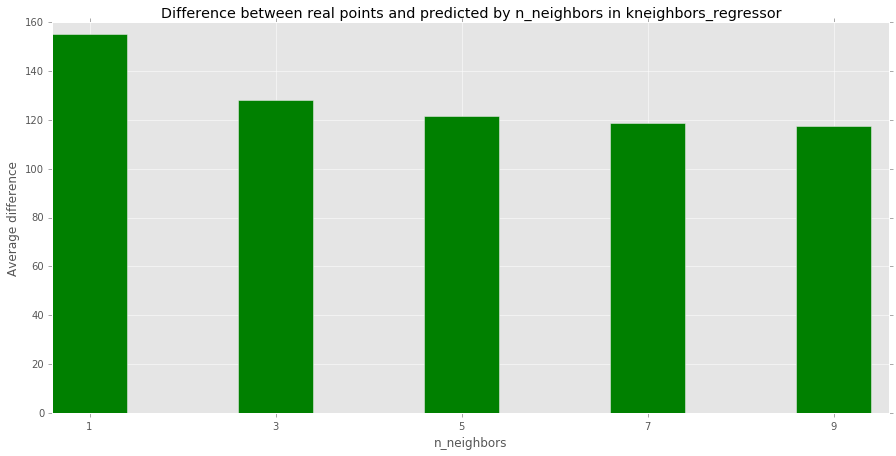

In [29]:
framework(function=kneighbors_regressor, test_results=test_results, parameter_name="n_neighbors",
          list_of_values=range(1, 10, 2), train_data=train_data, train_results=train_results, test_data=test_data)

1/2: 2016-10-10 16:02:35
2/2: 2016-10-10 16:03:02
done! 2016-10-10 16:03:29


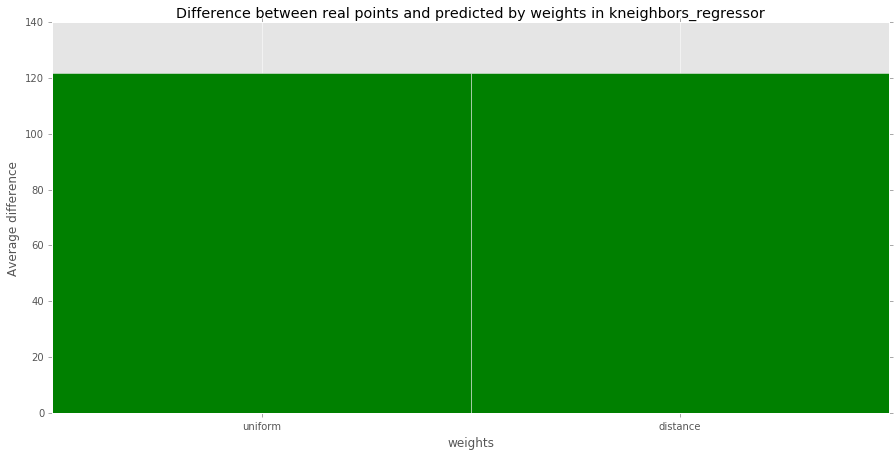

In [30]:
framework(function=kneighbors_regressor, test_results=test_results, parameter_name="weights",
          list_of_values=['uniform', 'distance'], train_data=train_data, train_results=train_results, test_data=test_data)

1/2: 2016-10-10 16:10:01
2/2: 2016-10-10 16:13:20
done! 2016-10-10 16:13:48


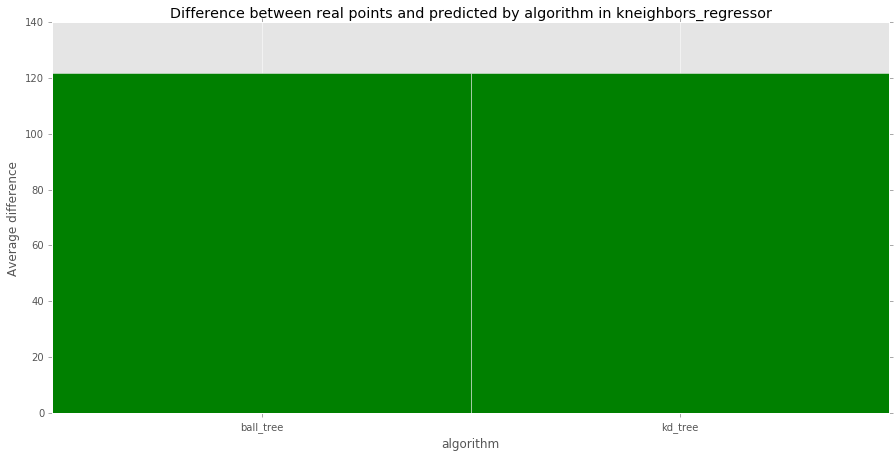

In [32]:
framework(function=kneighbors_regressor, test_results=test_results, parameter_name="algorithm",
          list_of_values=['ball_tree', 'kd_tree'], train_data=train_data, train_results=train_results,
          test_data=test_data)

As we can see there is no difference which algorithm to use: ball_tree or kd_tree but kd_tree works faster.

1/8: 2016-10-10 16:18:38
2/8: 2016-10-10 16:19:07
3/8: 2016-10-10 16:19:39
4/8: 2016-10-10 16:20:10
5/8: 2016-10-10 16:20:40
6/8: 2016-10-10 16:21:11
7/8: 2016-10-10 16:21:47
8/8: 2016-10-10 16:22:25
done! 2016-10-10 16:23:02


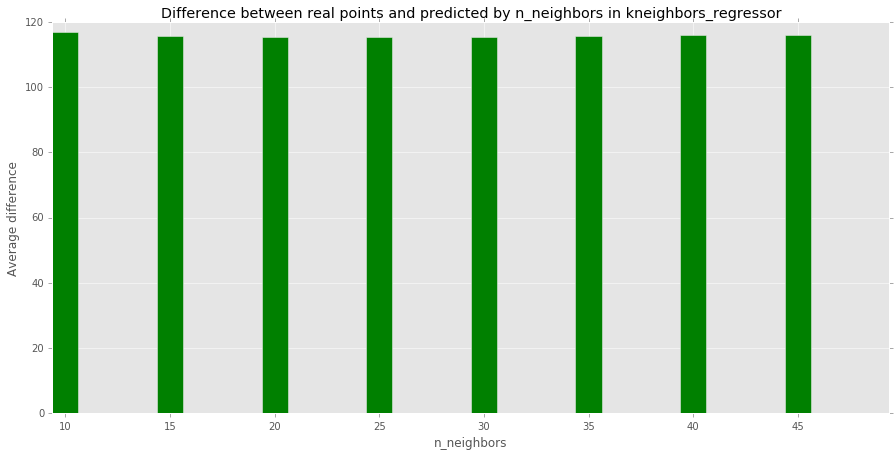

In [33]:
framework(function=kneighbors_regressor, test_results=test_results, parameter_name="n_neighbors",
          list_of_values=range(10, 50, 5), train_data=train_data, train_results=train_results, test_data=test_data)